# Практическая часть ДЗ 2

# Задача 1. Использование ALS для построения рекомендательной модели (35 баллов)

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [4]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A_{u,m}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{u,m}=1$) и отрицательные (`Rating < 4` &mdash; $A_{u,m} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)).

In [5]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [6]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

### a. (10 баллов) Вычисление ALS-функционала и расстояния между подпространствами

  1. **(5 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $\|A - UV^\top\|_F$ по всем $U$ и $V$ заданного ранга $r$. В самом алгоритме вместо двух матриц $U$ и $V$ естественным образом возникает третья матрица $S \in \mathbb{R}^{r \times r}$, так что текущее приближение выглядит как $USV^\top$. Поэтому первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - USV^\top\|_F$ для заданных $A$, $U$, $S$, $V^\top$ (матрица $S$ не обязана быть диагональной). Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - USV^\top\|_F^2$ через скалярное произведение $(X,Y)_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив). Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @. 

In [7]:
from math import sqrt

def als_functional(A, A_norm, U, S, Vt):
    """
        Input
            A: sparse 2D array mn
            A_norm: Frobenius norm of A
            U, S, VT: 2D arrays such that U @ S @ VT approximates A
        Output
            ||A - USVT||_F
    """
    
    def scalar_prod_mat(Xt, Y):
        trace = 0
        sz = Y.shape[1]
        for i in range(sz):
            trace += np.dot(Xt[i, :], Y[:, i])
        return trace
    
    res = 0
    # U mr S rr Vt rn A mn
    # ||A - USVt||_F^2 = A_norm^2 - 2<A, USVt> + <USVt, USVt>
    # <A, USVt> = tr(At U S Vt)
    
    R = S @ Vt # rn
    sc_1 = -2 * scalar_prod_mat(A.T @ U, R)
    # sc_1 = -2 * np.trace(A.T @ U @ R)
    
    # <USVt, USVt> = tr( V St Ut U S Vt ) =
    tmp = U.T @ U # rr
    # = tr( Rt tmp R) nr * rr * rn
    tmp = R.T @ tmp # nr
    sc_2 = scalar_prod_mat(tmp, R)
    
    res = A_norm * A_norm + sc_1 + sc_2
    
    return sqrt(res)

  2. **(3 балла)** Ещё одной метрикой сходимости ALS-процесса, помимо стабилизации самого функционала, может служить так называемое расстояние между подпространствами. Расстоянием между подпространствами $L_1 \subset \mathbb{R}^m$ и $L_2 \subset \mathbb{R}^m$ будем называть число $\|P(L_1) - P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Опишите алгоритм вычисления расстояния между двумя подпространствами $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^T U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь фактом, что ортопроекторы являются матрицами малого ранга $r$, и техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

**YOUR WORDS GO HERE**

Хотим: $\|P(L_1) - P(L_2)\|_2$, где $L_1 = Im(U_1),\ L_2 = Im(U_2)$. Как найти $P(L_i)$?

**Утв.** пусть $A \in \mathbb{C}^{m \times n}$ - полного ранга, m $\geqslant$ n. Тогда ортопроектор P на Im(A): $P = A(A^{*} A)^{-1} A^{*}$. В нашем случае как раз $U_1, U_2 \in \mathbb{R}^{m \times r}$. Тогда:
$P(L_i) = U_i(U_i^{T} U_i)^{-1} U_i^{T} = U_i(E)^{-1} U_i^{T} = U_i U_i^{T} \Longrightarrow P(L_1) = U_1 U_1^T,\ P(L_2) = U_2 U_2^T$.

По сути, $P(L_i) = U_i U_i^T$ можно считать готовым скелетным разложением ортопроектора - он как раз имеет ранг $r$. В лекции 3 п. 2 рассматривалась сумма двух матриц, представленных в виде скелетного разложения. Распишем такую же схему с вычитанием:\
$P(L_1) - P(L_2) = U_1 U_1^T - U_2 U_2^T = [U_1 (-U_2)] \times [U_1 U_2]^T$, где $[U_1 (-U_2)]$ имеет размер $m \times 2r$, а $[U_1 U_2]^T$ - $2r \times m$. А это - тоже скелетное разложение. Обозначим $A = [U_1 (-U_2)]$, $B = [U_1 U_2]$ и найдем QR-разложение от обеих матриц.

$A = Q_A R_A,\ B = Q_B R_B$, тогда $P(L_1) - P(L_2) = AB^T = Q_A R_A R_B^T Q_B^T$. $R_A,\ R_A^T$ имеют размер $2r \times 2r$, значит, их произведение посчитаем за $O(8r^3)$. За время такого же порядка ~$O(r^3)$ посчитаем SVD от произведения, и из матрицы сингулярных чисел возьмем старшее. Накладные расходы - конкатенация матриц, их слияние.


Общая структура алгоритма:
1. Получаем матрицы A и B засчет слияния - $O(mr)$
2. Считаем QR-разложение от каждой - $2O(4mr^2)$ ~ $O(mr^2)$
3. Вычисляем $R_A R_B^T$ и применяем сингулярное разложение - $2O(8r^3)$ ~ $O(r^3) \leqslant O(mr^2)$
4. Из полученного списка сингулярных значений выбираем первое - $O(1)$

Таким образом, легко видеть, что в итоге получаем сложность $O(mr^2)$, что и требовалось.

  3. **(2 балла)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние между $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [8]:
def dist_between_subspaces(U1, U2):
    A = np.concatenate([U1, -U2], axis = 1)
    B = np.concatenate([U1, U2], axis = 1)
    
    _, Ra = np.linalg.qr(A)
    _, Rb = np.linalg.qr(B)
    
    _, S, _ = np.linalg.svd(Ra @ Rb.T)
    return S[0]

### b. (12 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции). При указании `debug=True` печатайте номер текущей итерации и последнее расстояние между подпространствами, а также любую дополнительную интересную вам информацию. Вам будет необходимо вернуть три матрицы $U$, $S$, $V^\top$, а также список расстояний между $\mathrm{Im}(U_0)$ и $\mathrm{Im}(U_1)$, $...$, $\mathrm{Im}(U_{k-1})$ и $\mathrm{Im}(U_k)$. Матрицы $S$ не обязана быть диагональной.

In [9]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rk, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rk: required rank of the approximation
            tolerance: stop when this distance between Im(U_k) and Im(U_{k+1}) is reached
            debug: print debug information on each iteration
            
        Output
            U: m x rk numpy array with orthogonal columns
            S: rk x rk numpy array
            VT: rk x n numpy array with orthogonal rows
            dlist: list of distances between Im(U_k) and Im(U_{k+1})
    """
    m, n = A.shape
    
    V_pr, _ = np.linalg.qr(np.random.normal(size=(n, rk)))
    
    it = -1
    dlist = []
    dist = tolerance + 100
    
    while (True):
        Q_1, R_1 = np.linalg.qr(A @ V_pr)
        Q_2, R_2 = np.linalg.qr(A.T @ Q_1)
        
        U = Q_1
        V = Q_2
        S = R_2.T
        
        it += 1
        if (it > 0):
            dist = dist_between_subspaces(U_pr, U)
            dlist.append(dist)
            if (debug):
                print("Iteration:", it, "Distance:", dist)          

        if (dist <= tolerance):
            break
            
        U_pr = U
        V_pr = V
        
    return U, S, V.T, dlist

Запустим метод на матрице `A_train` и посмотрим на убывание расстояния между соседними подпространствами от номера итерации.

Iteration: 1 Distance: 0.8751827018121611
Iteration: 2 Distance: 0.5321037410833058
Iteration: 3 Distance: 0.3862043351580667
Iteration: 4 Distance: 0.27211931270715445
Iteration: 5 Distance: 0.20529796947180426
Iteration: 6 Distance: 0.16355467100636772
Iteration: 7 Distance: 0.1397435228195799
Iteration: 8 Distance: 0.12363038879900819
Iteration: 9 Distance: 0.1093468823533508
Iteration: 10 Distance: 0.09573279807072561
Time is taken: 19.45174503326416 seconds


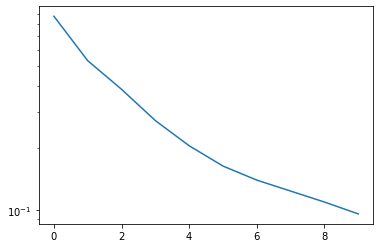

In [10]:
rank = 30
start_time = time.time()
U_als, S_als, VT_als, dist_als = ALS(A_train, rank, 0.1, debug=True)
print("Time is taken: %s seconds" % (time.time() - start_time))
plt.plot(dist_als)
_ = plt.semilogy()

### c. (3 балла) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также разреженное SVD из scipy (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

SVD: 1638.879474445028
Randomized SVD 1639.0243014958303
ALS 1639.5438617117406


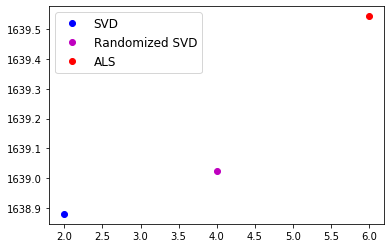

In [11]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)

U_1, S, Vt_1 = svds(A_train, k=rank)
S_1 = np.diag(S)

U_2, S, Vt_2 = randomized_svd(A_train, n_components=rank)
S_2 = np.diag(S)

res_1 = als_functional(A_train, A_norm, U_1, S_1, Vt_1)
res_2 = als_functional(A_train, A_norm, U_2, S_2, Vt_2)
res_3 = als_functional(A_train, A_norm, U_als, S_als, VT_als)

print("SVD:", res_1)
print("Randomized SVD", res_2)
print("ALS", res_3)

plt.plot(2, res_1, 'bo', label = 'SVD')
plt.plot(4, res_2, 'mo', label = 'Randomized SVD')
plt.plot(6, res_3, 'ro', label = 'ALS')
plt.legend(shadow = False, fontsize = 12)

### d. (10 баллов) Построение рекомендаций
Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.

In [12]:
import operator

def recommend(VT, known_ratings, n_recs):
    """
        Input
            VT: 2D numpy array
            known_rating: sparse batch_size x n_movies array
            n_recs: requested number of recommendations
            
        Output
            recs: batch_size x n_recs array of movies to recommend, with descending predicted rating
    """
    
    batch_size = known_ratings.shape[0]
    def get_dict(v):
        d = {i: v[i, 0] for i in range(v.shape[0])}
        return d
    
    V = VT.T
    rec_list = []
    #P = V @ VT
    # V имеет ортонормированные столбцы, значит, VT @ V = E, обратная тоже E
    # print(P.shape)
    
    rec_list = np.zeros((batch_size, n_recs), dtype=int)
    
    for index in range(batch_size):   
        ratings = V @ (VT @ known_ratings[index].T)
        dict_ratings = get_dict(ratings)
        
        dList = dict(sorted(dict_ratings.items(), key=operator.itemgetter(1), reverse=True))
        i = 0

        for item in dList:
            rec_list[index, i] = item
            i += 1
            if (i == n_recs):
                break
        
    return rec_list

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [13]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [14]:
def get_hit_rates(VT, A_test, n_recs):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users 
            n_recs: list of ints: number of top recomendations to evaluate hit rate for
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    hit_rates = []
    m = max(n_recs)
    hit_idx = evaluate_model(VT, A_test, m)
    for n in n_recs:
        rate = 0
        for i in range(len(hit_idx)):
            if (hit_idx[i] < n):
                rate += 1;

        rate /= len(hit_idx)
        hit_rates.append(rate)
        
    return hit_rates

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [15]:
start_time = time.time()
hits = get_hit_rates(VT_als, A_test[:1000, :], list([10]))
print("Time is taken: %s seconds" % (time.time() - start_time))

for hit in hits:
    print(hit * 100, "%", sep='')

Time is taken: 55.33494973182678 seconds
11.235955056179774%


Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

Time is taken: 590.9200727939606 seconds


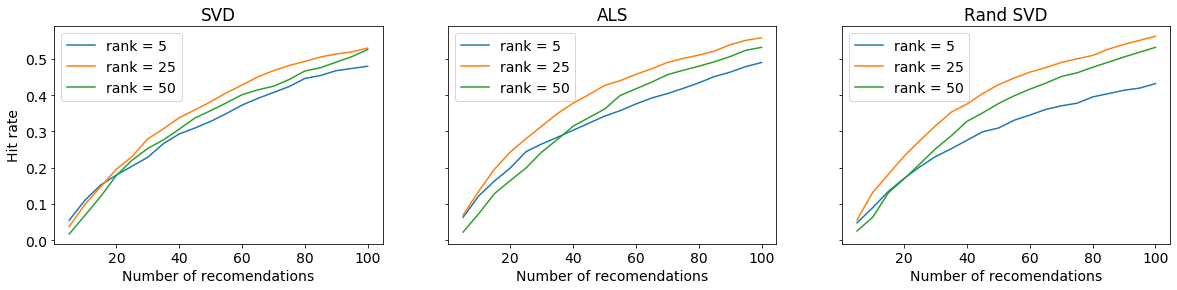

In [16]:
n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")

start_time = time.time()
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, _, VT_als, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()
print("Time is taken: %s seconds" % (time.time() - start_time))

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

Видно, что 25 - ок во всех случаях, но с рандомизированным SVD может быть по-другому (в силу рандома, конечно же).

# Задача 2. Higher-order SVD (25 баллов)

1. (**8 баллов**) Напишите функцию ```tuck2full(G, U, V, W)```, возвращающую полный тензор размера $n_1\times n_2 \times n_3$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U,V$ и $W$ строк меньше, чем столбцов. Это понадобится нам в дальнейшем. В этой задаче не разрешается использовать циклы. Вместо них используйте функцию ```np.einsum```.

In [17]:
def tuck2full(G, U, V, W):
    """
        Input
            G: 3D numpy array - Tucker core of size (r1, r2, r3)
            U: 2D numpy array - the first Tucker factor of size (n1, r1)
            V: 2D numpy array - the second Tucker factor of size (n2, r2)
            W: 2D numpy array - the third Tucker factor of size (n3, r3)

        Output
            A: 3D numpy array of the size (n1, n2, n3)
    """
    return np.einsum("ijk,ai,bj,gk->abg", G, U, V, W, optimize=True)
    # sum_{ijk}( G[ijk] * U[ai] * V[bj] * W[gk] ) = res[abg]

2. (**14 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного трехмерного массива $A\in\mathbb{R}^{n_1\times n_2 \times n_3}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. В этой задаче не разрешается пользоваться циклами. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [18]:
def hosvd(A, eps, ranks=False):
    print("Running...")
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: 3D numpy array - the Tucker core
            U: 2D numpy array - the first Tucker factor with orthogonal columns
            V: 2D numpy array - the second Tucker factor with orthogonal columns
            W: 2D numpy array - the third Tucker factor with orthogonal columns
    """
    m, n, l = A.shape[0], A.shape[1], A.shape[2]
    A_1, A_2, A_3 = A, np.transpose(A, [1, 0, 2]), np.transpose(A, [2, 0, 1])
    A_1 = np.reshape(A_1, (m, n * l), order='F')  # (1) unfolding
    A_2 = np.reshape(A_2, (n, m * l), order='F')  # (2) unfolding
    A_3 = np.reshape(A_3, (l, m * n), order='F')  # (3) unfolding
    
    def rk_approximation(A_i, eps):
        U_i, S, _ = np.linalg.svd(A_i, full_matrices=False)
        
        # A - Ar   => S = [0, 0, ..., 0, sigm_r, sigm_r+1, ...]
        # A - Ar+1 => S = [0, 0, ..., 0, 0,      sigm_r+1, ...]
        
        rk = len(S) - 1
        A_i_norm = sqrt(sum(S ** 2))
        while np.linalg.norm(A_i - U_i[:, :rk] @ U_i[:, :rk].T @ A_i) <= eps / A_i_norm:
            rk -= 1
    
        U_i =  U_i[:, :rk]
        return U_i


    U_1 = rk_approximation(A_1, eps)
    U_2 = rk_approximation(A_2, eps)
    U_3 = rk_approximation(A_3, eps)
    
    G = tuck2full(A, U_1.T, U_2.T, U_3.T)
    
    if (ranks):
        print("R1: ", G.shape[0])
        print("R2: ", G.shape[1])
        print("R3: ", G.shape[2])
    
    print("Success!")
    return G, U_1, U_2, U_3

3. (**3 балла**) Примените функцию ```hosvd``` к тензору размера $100 \times 200 \times 300$ с элементами
$$
    a_{ijk} = \frac{1}{i + j + k + 1}, \quad i,j,k=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [19]:
A = np.zeros((100, 200, 300), dtype=float)
for i in range(100):
    for j in range(200):
        for k in range(300):
            A[i, j, k] = 1 / (i + j + k + 1)

start_time = time.time()
G, U, V, W = hosvd(A, 1e-6, ranks=True)
error = np.linalg.norm((A - tuck2full(G, U, V, W)))
print("Error:", error)
print("Time is taken: %s seconds" % (time.time() - start_time))

Running...
R1:  12
R2:  13
R3:  13
Success!
Error: 2.052186966996787e-07
Time is taken: 68.51240992546082 seconds


Конечно, можно было бы сделать и побыстрее, но:\
 "Premature optimization is the root of all evil". Donald Ervin Knuth.